# Handwritten Digit Classifier

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data Preparation & Augmentation

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Augmentation and Normalization for MNIST
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))# Mean and Std for MNIST
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Using device: cpu


In [4]:
# Load Datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

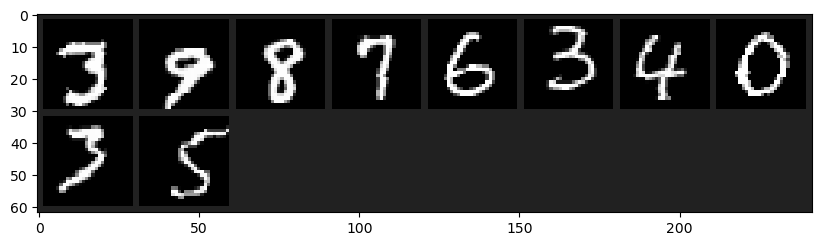

Labels: 3 9 8 7 6 3 4 0 3 5


In [5]:
def imshow(img):
    img = img * 0.3081 + 0.1307  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:10]))
print('Labels:', ' '.join(str(labels[j].item()) for j in range(10)))

### CNN Architecture Design

In [6]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        # 1st Convolutional Layer: Input = 1x28x28, Output = 32x26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)

        # 2nd Convolutional Layer: Input = 32x13x13, Output = 64x11x11
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))   # Conv1 + ReLU
        x = self.pool(x)            # Max Pooling
        x = F.relu(self.conv2(x))   # Conv2 + ReLU
        x = self.pool(x)            # Max Pooling
        x = x.view(-1, 64 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))     # FC1 + ReLU
        x = self.fc2(x)             # FC2 (Output layer)
        return x

In [7]:
model = DigitCNN().to(device)
print(model)

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Model Training and Evaluation 

In [8]:
# Define Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training Loop
epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Epoch [1/5], Loss: 0.2793, Test Accuracy: 98.42%
Epoch [2/5], Loss: 0.0947, Test Accuracy: 98.54%
Epoch [3/5], Loss: 0.0734, Test Accuracy: 99.08%
Epoch [4/5], Loss: 0.0601, Test Accuracy: 98.67%
Epoch [5/5], Loss: 0.0542, Test Accuracy: 99.05%


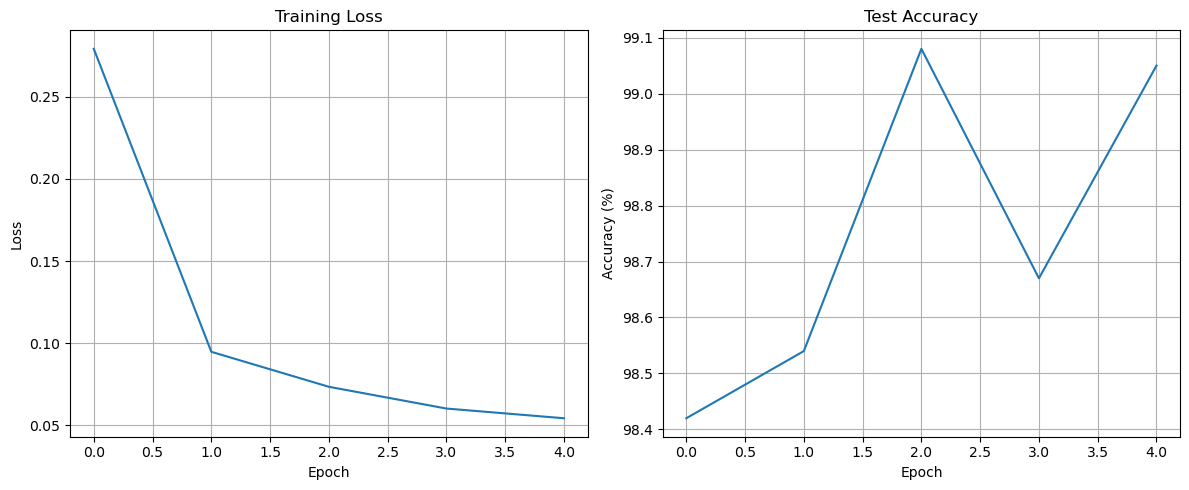

In [10]:
# Plotting Training Loss and Test Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Get all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

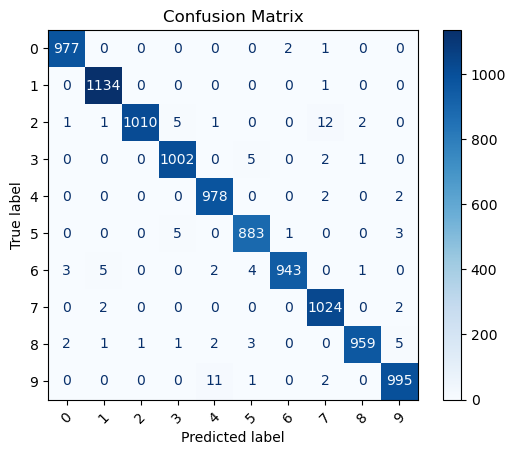

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.savefig("utils/confusion_matrix.png")
plt.show()

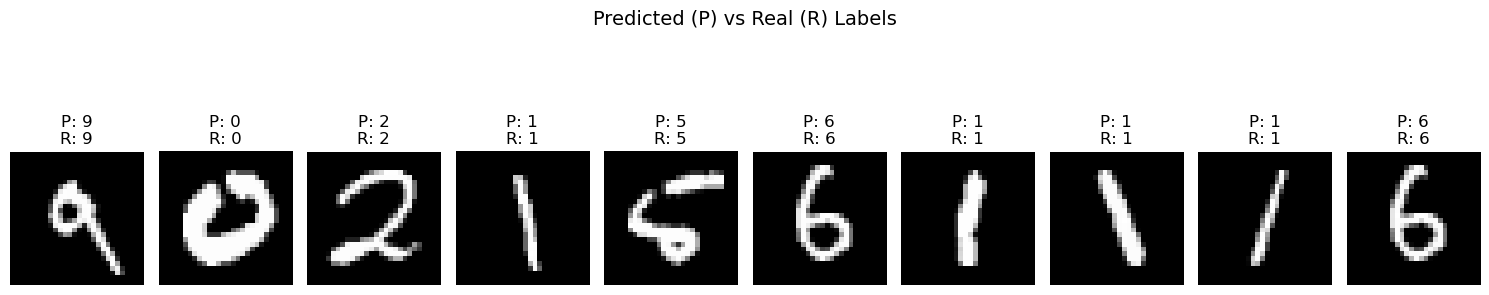

In [ ]:
# Get a batch from test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Run through the model
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Visualize 10 random predictions
plt.figure(figsize=(15,4))
for i in range(10):
    idx = random.randint(0, len(images) - 1)
    img = images[idx].cpu().squeeze().numpy()
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"P: {preds[idx].item()}\nR: {labels[idx].item()}")
    plt.axis('off')

plt.suptitle("Predicted (P) vs Real (R) Labels", fontsize=14)
plt.tight_layout()
plt.savefig("utils/sample_predictions.png")
plt.show()